# Introduction to `tidyverse` Round 2
An ["opinionated" collection of R packages](https://tidyverse.org) for data science, driven by a coherent underlying design philosophy.
These packages are meant to help you with two essential processes:
1. **Data clean-up and organization**: Structure should be intuitive, so that it's easy to model, manipulate, and think about the data
2. **Data plotting**: The grammar of graphics (Week 13)

In [3]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Data preparation

### Loading the data

In [4]:
data <- read_csv("data/148338_220209_095045_M057814.csv", skip=2)

Rows: 241 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (21): type, stim1, stim2, stimPos, stimFormat, feedbackIncorrect, head, ...
dbl (11): rowNo, ITI, feedbackTime, random, ITI_ms, ITI_f, ITI_fDuration, ti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
education_level <- data %>% pull(response) %>% first()  

data <- data %>%
    # Keep only useful columns
    select(c(rowNo, type, stim1, stim2, stimPos, trialType, response, RT)) %>%
    
    # Keep only useful rows
    filter(type != "form") %>%
    
    # Add demographic and trial-number info, turn trial type to factor
    mutate(
        education_level = education_level, # Add info
        trial_number = row_number(),
        trialType = factor(trialType, levels = c("incongruent", "congruent"))
    ) %>%
    
    # Rename trialType to trial_type
    rename(trial_type = trialType)

head(data)

rowNo,type,stim1,stim2,stimPos,trial_type,response,RT,education_level,trial_number
<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<int>
190,test,croissantLarge,breadSmall,-341 0; 341 0,incongruent,j,729,College or Technical School,1
125,test,lampSmall,shelfLarge,-235 0; 235 0,congruent,f,625,College or Technical School,2
200,test,schoolbusLarge,bikeSmall,-370 0; 370 0,congruent,j,1477,College or Technical School,3
152,test,orangeLarge,raspberrySmall,-307 0; 307 0,congruent,j,793,College or Technical School,4
110,test,hammerLarge,ladderSmall,-156 0; 156 0,incongruent,j,900,College or Technical School,5
215,test,wheelSmall,coinLarge,-300 0; 300 0,incongruent,f,699,College or Technical School,6


### Tidying the data

Our data is almost tidy, but we still need to do several things.

#### Exercise 1
There are two columns that are uninformative. Remove them.

In [6]:
data <- data %>%
    select(-c(rowNo, stimPos))

#### Exercise 2
The columns `stim1` and `stim2` refer to the stimulus presented on the left and, respectively, right. Rename the columns to make them more informative.

In [7]:
data <- data %>% rename(stim_left = stim1, stim_right = stim2)

#### Exercise 3
Add a new column called `subject_id` and set this participant to 1.

In [8]:
data <- data %>% mutate(subject_id = 1)

#### Exercise 4
Add a new column called `correct_side`. This column should encode the side of the correct answer (equivalently, the side of the smaller image). Use `str_detect(string, pattern)` to compute where the smaller image was on the screen and use a conditional `mutate` to fill in the values of `correct_side`.

In [10]:
data <- data %>% 
    mutate(correct_side = ifelse(str_detect(stim_left, "Small"), "left", "right"))
head(data)

type,stim_left,stim_right,trial_type,response,RT,education_level,trial_number,subject_id,correct_side
<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<int>,<dbl>,<chr>
test,croissantLarge,breadSmall,incongruent,j,729,College or Technical School,1,1,right
test,lampSmall,shelfLarge,congruent,f,625,College or Technical School,2,1,left
test,schoolbusLarge,bikeSmall,congruent,j,1477,College or Technical School,3,1,right
test,orangeLarge,raspberrySmall,congruent,j,793,College or Technical School,4,1,right
test,hammerLarge,ladderSmall,incongruent,j,900,College or Technical School,5,1,right
test,wheelSmall,coinLarge,incongruent,f,699,College or Technical School,6,1,left


#### Exercise 5
Add a new column called `correct_key`. This column should be equal to `f` if the smaller image was on the left, and to `j` if the smaller image was on the right.

In [11]:
data <- data %>% 
    mutate(correct_key = ifelse(correct_side == "left", "f", "j"))

#### Exercise 6
Add a new column called `correct`. This column should be equal to 1 if the participant provided a correct response, 0 otherwise.

In [13]:
data <- data %>% 
    mutate(correct = ifelse(response == correct_key, 1, 0))
head(data)

type,stim_left,stim_right,trial_type,response,RT,education_level,trial_number,subject_id,correct_side,correct_key,correct
<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>
test,croissantLarge,breadSmall,incongruent,j,729,College or Technical School,1,1,right,j,1
test,lampSmall,shelfLarge,congruent,f,625,College or Technical School,2,1,left,f,1
test,schoolbusLarge,bikeSmall,congruent,j,1477,College or Technical School,3,1,right,j,1
test,orangeLarge,raspberrySmall,congruent,j,793,College or Technical School,4,1,right,j,1
test,hammerLarge,ladderSmall,incongruent,j,900,College or Technical School,5,1,right,j,1
test,wheelSmall,coinLarge,incongruent,f,699,College or Technical School,6,1,left,f,1


#### Exercise 7
The experiment had 240 trials, equally divided into two blocks. Add a new column called `trial_block` that encodes this.

In [14]:
data <- data %>% 
    mutate(trial_block = ifelse(trial_number <= 120, 1, 2))

#### Exercise 8
Recode `trial_number` so that it codes the trial number within a block. Instead of going from 1 to 240, it should go from 1 to 120 twice.

In [15]:
data <- data %>% 
    mutate(trial_number = ifelse(trial_number > 120, trial_number - 120, trial_number))

#### Exercise 9
It is good practice to use a consistent style throughout your script. One such style is called **snake**, the standard in python, which uses only lowercase letters and underscores: `variable_name`. Another common style is **camel**, the standard in JavaScript, which uses capital letters to mark the beginning of a new word: `variableName`. Our tibble at this point uses both styles, so turn all variable names to snake case. You can use `colnames` to see the vector of column names.

In [16]:
data <- data %>% 
    rename(rt = RT)

#### Exercise 10
Using `select`, reorder the columns such that participant information comes first, followed by trial block and number, followed by trial info.

In [ ]:
data %>% colnames()
data %>% select(subject_id, education_level, trial_block, trial_number, trial_type, stim_left, stim_right, correct_side, correct_key, response, correct, rt)

[1] "type"            "stim_left"       "stim_right"      "trial_type"     
 [5] "response"        "rt"              "education_level" "trial_number"   
 [9] "subject_id"      "correct_side"    "correct_key"     "correct"        
[13] "trial_block"

subject_id,education_level,trial_block,trial_number,trial_type,stim_left,stim_right,correct_side,correct_key,response,correct,rt
<dbl>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,College or Technical School,1,1,incongruent,croissantLarge,breadSmall,right,j,j,1,729
1,College or Technical School,1,2,congruent,lampSmall,shelfLarge,left,f,f,1,625
1,College or Technical School,1,3,congruent,schoolbusLarge,bikeSmall,right,j,j,1,1477
1,College or Technical School,1,4,congruent,orangeLarge,raspberrySmall,right,j,j,1,793
1,College or Technical School,1,5,incongruent,hammerLarge,ladderSmall,right,j,j,1,900
1,College or Technical School,1,6,incongruent,wheelSmall,coinLarge,left,f,f,1,699
1,College or Technical School,1,7,incongruent,coconutSmall,blueberryLarge,left,f,f,1,752
1,College or Technical School,1,8,congruent,pumpkinLarge,mushroomSmall,right,j,j,1,567
1,College or Technical School,1,9,congruent,croissantSmall,breadLarge,left,f,f,1,556


#### Exercise 11
Concatenate all the commands in Exercises 1–10 into a single cell and store the output in a variable called `tidy_data`.

In [24]:
tidy_data <- read_csv("data/148338_220209_095045_M057814.csv", skip=2) %>%
    select(c(rowNo, type, stim1, stim2, stimPos, trialType, response, RT)) %>%
    filter(type != "form") %>%
    mutate(
        education_level = "High School", # Hardcoded for this single subject example as per previous cells
        trial_number = row_number(),
        trialType = factor(trialType, levels = c("incongruent", "congruent"))
    ) %>%
    rename(trial_type = trialType) %>%
    select(-c(rowNo, stimPos)) %>%
    rename(stim_left = stim1, stim_right = stim2) %>%
    mutate(subject_id = 1) %>%
    mutate(correct_side = ifelse(str_detect(stim_left, "Small"), "left", "right")) %>%
    mutate(correct_key = ifelse(correct_side == "left", "f", "j")) %>%
    mutate(correct = ifelse(response == correct_key, 1, 0)) %>%
    mutate(trial_block = ifelse(trial_number <= 120, 1, 2)) %>%
    mutate(trial_number = ifelse(trial_number > 120, trial_number - 120, trial_number)) %>%
    rename(rt = RT) %>%
    select(subject_id, education_level, trial_block, trial_number, trial_type, stim_left, stim_right, correct_side, correct_key, response, correct, rt)

head(tidy_data)

Rows: 241 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (21): type, stim1, stim2, stimPos, stimFormat, feedbackIncorrect, head, ...
dbl (11): rowNo, ITI, feedbackTime, random, ITI_ms, ITI_f, ITI_fDuration, ti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


subject_id,education_level,trial_block,trial_number,trial_type,stim_left,stim_right,correct_side,correct_key,response,correct,rt
<dbl>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,High School,1,1,incongruent,croissantLarge,breadSmall,right,j,j,1,729
1,High School,1,2,congruent,lampSmall,shelfLarge,left,f,f,1,625
1,High School,1,3,congruent,schoolbusLarge,bikeSmall,right,j,j,1,1477
1,High School,1,4,congruent,orangeLarge,raspberrySmall,right,j,j,1,793
1,High School,1,5,incongruent,hammerLarge,ladderSmall,right,j,j,1,900
1,High School,1,6,incongruent,wheelSmall,coinLarge,left,f,f,1,699


### Summary statistics

In [25]:
tidy_data %>%
    summarize(rt = mean(rt), accuracy = mean(correct), error = mean(1 - correct))

rt,accuracy,error
<dbl>,<dbl>,<dbl>
622.7542,0.9833333,0.01666667


In [31]:
tidy_data %>%
    mutate(avg_error = mean(1 - correct))

subject_id,education_level,trial_block,trial_number,trial_type,stim_left,stim_right,correct_side,correct_key,response,correct,rt,avg_error
<dbl>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,High School,1,1,incongruent,croissantLarge,breadSmall,right,j,j,1,729,0.01666667
1,High School,1,2,congruent,lampSmall,shelfLarge,left,f,f,1,625,0.01666667
1,High School,1,3,congruent,schoolbusLarge,bikeSmall,right,j,j,1,1477,0.01666667
1,High School,1,4,congruent,orangeLarge,raspberrySmall,right,j,j,1,793,0.01666667
1,High School,1,5,incongruent,hammerLarge,ladderSmall,right,j,j,1,900,0.01666667
1,High School,1,6,incongruent,wheelSmall,coinLarge,left,f,f,1,699,0.01666667
1,High School,1,7,incongruent,coconutSmall,blueberryLarge,left,f,f,1,752,0.01666667
1,High School,1,8,congruent,pumpkinLarge,mushroomSmall,right,j,j,1,567,0.01666667
1,High School,1,9,congruent,croissantSmall,breadLarge,left,f,f,1,556,0.01666667


#### Exercise 12
Using the `.by` argument in the call to `summarize`, find out if our participant showed the predicted size Stroop in reaction times and error rates.

In [32]:
tidy_data %>%
    summarize(rt = mean(rt), error = mean(1 - correct), .by = trial_type)

trial_type,rt,error
<fct>,<dbl>,<dbl>
incongruent,698.1000,0.03333333
congruent,547.4083,0.00000000


#### Exercise 13
Using a similar logic, find out if our participant also showed a SNARC effect: Was the participant faster when the small image was on the left?

In [33]:
tidy_data %>%
    summarize(rt = mean(rt), .by = correct_side)

correct_side,rt
<chr>,<dbl>
right,632.7333
left,612.7750


#### Exercise 14
Find out if the SNARC effect depends on trial type.

In [34]:
tidy_data %>%
    summarize(rt = mean(rt), .by = c(trial_type, correct_side))

trial_type,correct_side,rt
<fct>,<chr>,<dbl>
incongruent,right,694.9167
congruent,left,524.2667
congruent,right,570.5500
incongruent,left,701.2833


## From a single participant to a full dataset
We load all the 12 csv files in the 'data' folder, then apply the `read_csv` function to each of them using `map_dfr`. The `.id` argument creates a column that keeps the information from each file separate. This is equivalent to having a subject_id, if there is one .csv file per participant.

In [35]:
# Fetch all the files in the 'data' folder that end in .csv
raw_data <- list.files(path = 'data', pattern = ".csv$", full.names = TRUE) %>% 

  # Map the read_csv function to all of them, skipping the first 2 rows and creating a new id column called 'id' so that each file gets its own id
  # col_types = cols() just makes explicit that you want tidyverse to do its best to guess the type of each column (string, numeric, etc.)
  map_dfr(read_csv, col_types = cols(), skip = 2, .id = 'id') 

#### Exercise 15
Tidy the dataset exactly as we did for subject 1, while keeping the education-level information for each subject. Store it as `tidy_data`.

Hint: **group** the tibble before calling `first(response)`), then follow the same steps as before to obtain a tidy dataset. Use `ungroup()` to return to the tibble to the ungrouped state. In fact, in most of the exercises that follow, you will need to use grouping wisely.

```R
full_data <- raw_data %>% 
    mutate(education_level = first(response), .by = id) %>%
    ...
```

In [ ]:
full_data <- raw_data %>%

    mutate(education_level = first(response), .by = id) %>%
    ungroup() %>%
    filter(trialType != "form") %>%
    mutate(trial_number = row_number()) %>%
    ungroup() %>%
    select(c(id, education_level, trial_number, trialType, stim1, stim2, response, RT)) %>%
    rename(trial_type = trialType, stim_left = stim1, stim_right = stim2, rt = RT) %>%
    mutate(
        correct_side = ifelse(str_detect(stim_left, "Small"), "left", "right"),
        correct_key = ifelse(correct_side == "left", "f", "j"),
        correct = ifelse(response == correct_key, 1, 0),
        trial_block = ifelse(trial_number <= 120, 1, 2),
        trial_number = ifelse(trial_number > 120, trial_number - 120, trial_number)
    )

#### Exercise 16
Trials where the responses were too slow or too fast should be excluded from the analysis. (Why?)  
Exclude the trials where the response is below 200 ms or higher than 1,500 ms. How many trials were excluded?

In [52]:
filtered_trials <- full_data %>%
    filter(rt >= 200 & rt <= 1500)

n_excluded <- nrow(full_data) - nrow(filtered_trials)
print(n_excluded)

[1] 284


#### Exercise 17 
Exclude participants who didn't achieve 93% overall accuracy.  
How many subjects were excluded?

In [53]:
subject_accuracy <- filtered_trials %>%
    summarize(acc = mean(correct), .by = id)

keep_ids <- subject_accuracy %>%
    filter(acc >= 0.93) %>%
    pull(id)

filtered_id <- filtered_trials %>%
    filter(id %in% keep_ids)

n_excluded_subj <- n_distinct(filtered_trials$id) - n_distinct(filtered_id$id)
print(n_excluded_subj)

[1] 1


#### Exercise 18
Summarize the response-time and accuracy measures by trial type to check whether there's a Stroop effect.

In [54]:
filtered_id %>%
    summarize(rt = mean(rt), accuracy = mean(correct), .by = trial_type)

trial_type,rt,accuracy
<chr>,<dbl>,<dbl>
incongruent,814.4211,0.935289
congruent,707.7510,0.994152


## Changing the format of the data: `pivot_wider`, `pivot_longer`

#### Exercise 19: `pivot_wider`
Compute the average Stroop effects for each participant. One column should be called `stroop_rt`, the other should be called `stroop_error`. Using `pull`, extract the reaction-time Stroop vector and plot its histogram.

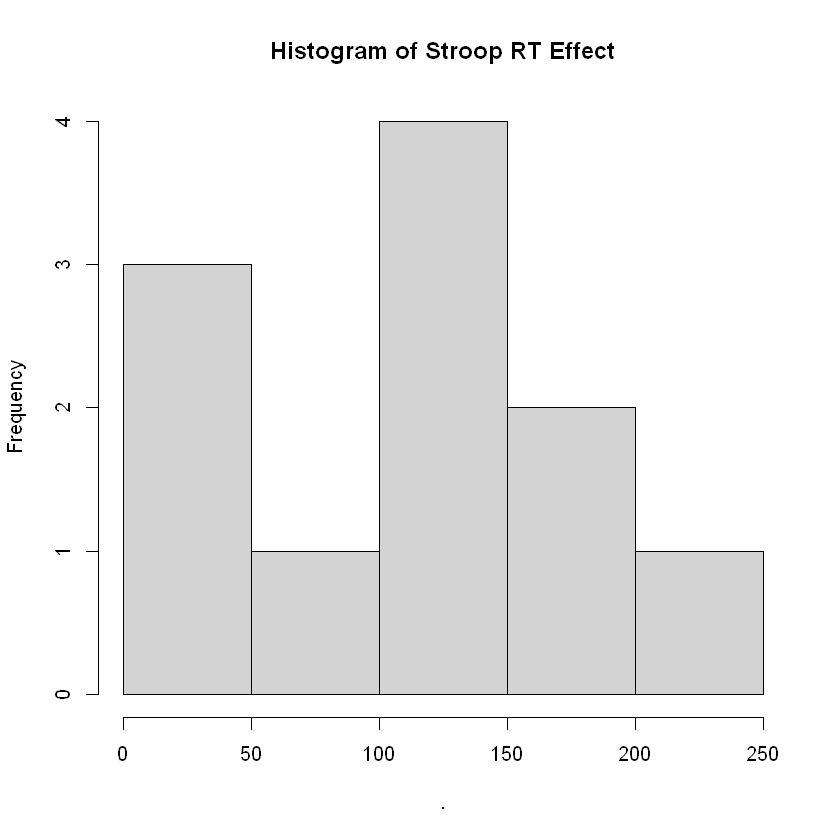

In [55]:
stroop_effects <- filtered_id %>%
    summarize(rt = mean(rt), error = mean(1 - correct), .by = c(id, trial_type)) %>%
    pivot_wider(names_from = trial_type, values_from = c(rt, error)) %>%
    mutate(
        stroop_rt = rt_incongruent - rt_congruent,
        stroop_error = error_incongruent - error_congruent
    )

stroop_effects %>% pull(stroop_rt) %>% hist(main="Histogram of Stroop RT Effect")

#### Exercise 20: `pivot_longer`
Building on the output tibble in Exercise 19, remove all columns except `id`, `stroop_rt`, and `stroop_error`, then gather the two stroop columns into a single column called `measure`. This column should take one of two values for each subject (`stroop_rt` or `stroop_error`), while the `value` column should register the respective participants' stroop effect.

In [56]:
stroop_long <- stroop_effects %>%
    select(id, stroop_rt, stroop_error) %>%
    pivot_longer(cols = c(stroop_rt, stroop_error), names_to = "measure", values_to = "value")

head(stroop_long)

id,measure,value
<chr>,<chr>,<dbl>
1,stroop_rt,136.54929379
1,stroop_error,0.03389831
2,stroop_rt,15.50925926
2,stroop_error,0.06481481
3,stroop_rt,126.06837607
3,stroop_error,0.08547009


## Data plotting

### Rule 1: If your data is in the tidy format (one variable per column, one observation per row), plotting with `ggplot` will be very easy.

### Rule 2: No barplots.

### One possible way to do it

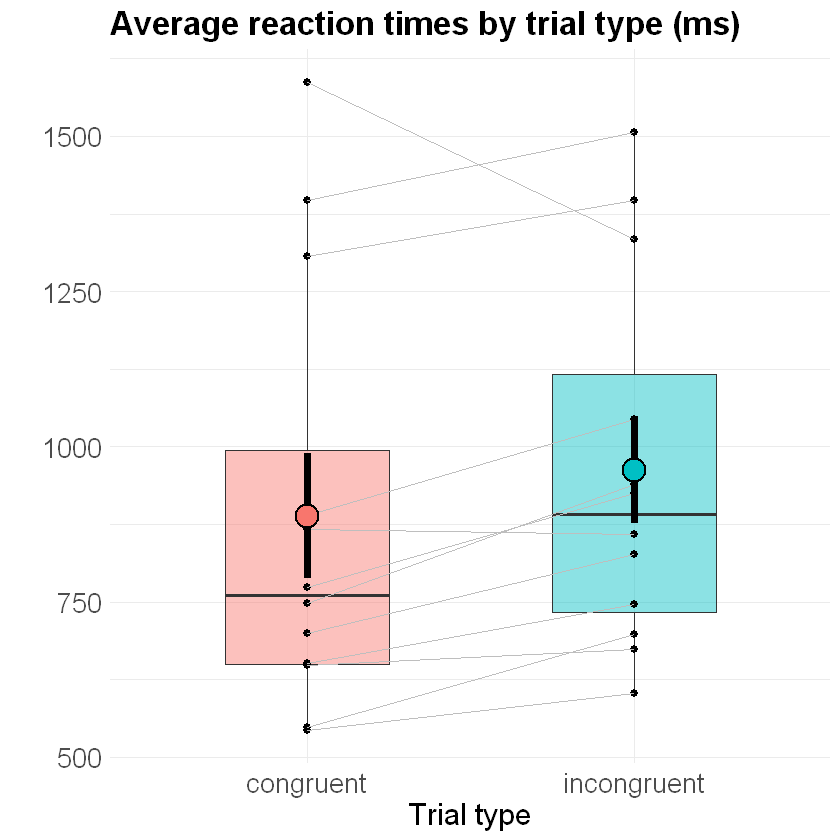

In [58]:
average_data <- full_data %>% summarize(rt = mean(rt), .by = c(id, trial_type)) 

ggplot(average_data, aes(x = trial_type, y = rt, fill = trial_type)) +
  geom_boxplot(width = 0.5, alpha = 0.45) +
  geom_point(size = 2) +
  geom_line(aes(group = id), color = 'gray') +         
  stat_summary(fun.data = mean_se, linewidth = 2, shape = 21, size = 1.5) +
  labs(title = "Average reaction times by trial type (ms)", x = "Trial type", y = "") +
  theme_minimal() + 
  theme(
    legend.position = "none", 
    plot.title = element_text(face = "bold", size = 20),
    axis.title = element_text(size = 18),
    axis.text = element_text(size = 16))